In [1]:
# General Packages
import math
import os
from pathlib import Path

# data handling libraries
import pandas as pd
import numpy as np
from tabulate import tabulate

# visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

# extra libraries
import warnings
warnings.filterwarnings('ignore')

# Packages to support NN

# sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#tensorflow
import tensorflow as tf
from tensorflow import keras

# Keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

from rich.progress import Progress
import time

In [2]:
# Function to evaluate predicted vs test data categorical variables
def plot_prediction_vs_test_categorical(y_test, y_pred, class_labels):
    # Plots the prediction vs test data for categorical variables.

    # Args:
    #     y_test (array-like): True labels of the test data.
    #     y_pred (array-like): Predicted labels of the test data.
    #     class_labels (list): List of class labels.

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Calculates performance of multivariate classification model
def calculate_performance_multiclass(y_true, y_pred):
    # Calculates various performance metrics for multiclass classification.

    # Args:
    #     y_true: The true labels.
    #     y_pred: The predicted labels.

    # Returns:
    #     A dictionary containing the calculated metrics.

    metrics = {}

    # Accuracy
    metrics['accuracy'] = accuracy_score(y_true, y_pred)

    # Precision, Recall, and F1-score (macro-averaged)
    metrics['precision'] = precision_score(y_true, y_pred, average='macro')
    metrics['recall'] = recall_score(y_true, y_pred, average='macro')
    metrics['f1_score'] = f1_score(y_true, y_pred, average='macro')

    # Confusion Matrix
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)

    return metrics

In [3]:
# load training data from current dir
current_dir = os.getcwd()

file_path = os.path.join(current_dir, "clean_training_andy.csv")

df = pd.read_csv(file_path)

print((df.Status == "IC").sum())
print((df.Status == "AA").sum())
print((df.Status == "AO").sum())
print((df.Status == "JO").sum())
print((df.Status == "JA").sum())


print(df.info())

189138
17474
28261
569
752
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236194 entries, 0 to 236193
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   DR_NO_INDEX      236194 non-null  int64  
 1   AREA             236194 non-null  int64  
 2   Rpt Dist No      236194 non-null  int64  
 3   Crm Cd           236194 non-null  int64  
 4   Vict Age         236194 non-null  int64  
 5   Vict Sex         236194 non-null  object 
 6   Vict Descent     236194 non-null  object 
 7   Premis Cd        236194 non-null  float64
 8   Weapon Used Cd   236194 non-null  float64
 9   Status           236194 non-null  object 
 10  Target           236194 non-null  object 
 11  MONTH OCC        236194 non-null  int64  
 12  TIME PERIOD OCC  236194 non-null  object 
dtypes: float64(2), int64(6), object(5)
memory usage: 23.4+ MB
None


In [4]:
# load testing data from current dir
current_dir = os.getcwd()

file_path = os.path.join(current_dir, "clean_testing_andy.csv")

df2 = pd.read_csv(file_path)


print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43576 entries, 0 to 43575
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DR_NO_INDEX      43576 non-null  int64  
 1   AREA             43576 non-null  int64  
 2   Rpt Dist No      43576 non-null  int64  
 3   Crm Cd           43576 non-null  int64  
 4   Vict Age         43576 non-null  int64  
 5   Vict Sex         43576 non-null  object 
 6   Vict Descent     43576 non-null  object 
 7   Premis Cd        43576 non-null  float64
 8   Weapon Used Cd   43576 non-null  float64
 9   Status           43576 non-null  object 
 10  Target           43576 non-null  object 
 11  MONTH OCC        43576 non-null  int64  
 12  TIME PERIOD OCC  43576 non-null  object 
dtypes: float64(2), int64(6), object(5)
memory usage: 4.3+ MB
None


In [5]:
# set variables for model
target = ['Status']
numerical = ['AREA', 'Rpt Dist No', 'Crm Cd', 'Vict Age', 'Premis Cd', 'Weapon Used Cd', 'MONTH OCC']
# uses too much memory when Mocodes is used but would like to include it
categorical = ['Target', 'Vict Sex', 'Vict Descent', 'TIME PERIOD OCC']

In [6]:
# set up encoder
encoder = OneHotEncoder(handle_unknown='ignore')

le = LabelEncoder()

In [7]:
# encoding categorical values for training
encoded_features = encoder.fit_transform(df[categorical])

# convert encoded data to a dataframe
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical))

# combine dataframes
df = pd.concat([df, encoded_df], axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236194 entries, 0 to 236193
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DR_NO_INDEX         236194 non-null  int64  
 1   AREA                236194 non-null  int64  
 2   Rpt Dist No         236194 non-null  int64  
 3   Crm Cd              236194 non-null  int64  
 4   Vict Age            236194 non-null  int64  
 5   Vict Sex            236194 non-null  object 
 6   Vict Descent        236194 non-null  object 
 7   Premis Cd           236194 non-null  float64
 8   Weapon Used Cd      236194 non-null  float64
 9   Status              236194 non-null  object 
 10  Target              236194 non-null  object 
 11  MONTH OCC           236194 non-null  int64  
 12  TIME PERIOD OCC     236194 non-null  object 
 13  Target_Arrest       236194 non-null  float64
 14  Target_No Arrest    236194 non-null  float64
 15  Vict Sex_F          236194 non-nul

In [8]:
# encoding categorical values for testing
encoded_features2 = encoder.fit_transform(df2[categorical])

# convert encoded data to a dataframe
encoded_df2 = pd.DataFrame(encoded_features2.toarray(), columns=encoder.get_feature_names_out(categorical))

# combine dataframes
df2 = pd.concat([df2, encoded_df2], axis=1)

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43576 entries, 0 to 43575
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DR_NO_INDEX         43576 non-null  int64  
 1   AREA                43576 non-null  int64  
 2   Rpt Dist No         43576 non-null  int64  
 3   Crm Cd              43576 non-null  int64  
 4   Vict Age            43576 non-null  int64  
 5   Vict Sex            43576 non-null  object 
 6   Vict Descent        43576 non-null  object 
 7   Premis Cd           43576 non-null  float64
 8   Weapon Used Cd      43576 non-null  float64
 9   Status              43576 non-null  object 
 10  Target              43576 non-null  object 
 11  MONTH OCC           43576 non-null  int64  
 12  TIME PERIOD OCC     43576 non-null  object 
 13  Target_Arrest       43576 non-null  float64
 14  Target_No Arrest    43576 non-null  float64
 15  Vict Sex_F          43576 non-null  float64
 16  Vict

In [9]:
#handle the target for training 
encoded_target = encoder.fit_transform(df[target])

encoded_target_df = pd.DataFrame(encoded_target.toarray(), columns=encoder.get_feature_names_out(target))

df = pd.concat([df, encoded_target_df], axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236194 entries, 0 to 236193
Data columns (total 45 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DR_NO_INDEX         236194 non-null  int64  
 1   AREA                236194 non-null  int64  
 2   Rpt Dist No         236194 non-null  int64  
 3   Crm Cd              236194 non-null  int64  
 4   Vict Age            236194 non-null  int64  
 5   Vict Sex            236194 non-null  object 
 6   Vict Descent        236194 non-null  object 
 7   Premis Cd           236194 non-null  float64
 8   Weapon Used Cd      236194 non-null  float64
 9   Status              236194 non-null  object 
 10  Target              236194 non-null  object 
 11  MONTH OCC           236194 non-null  int64  
 12  TIME PERIOD OCC     236194 non-null  object 
 13  Target_Arrest       236194 non-null  float64
 14  Target_No Arrest    236194 non-null  float64
 15  Vict Sex_F          236194 non-nul

In [10]:
#handle the target for testing

encoded_target2 = encoder.fit_transform(df2[target])

encoded_target_df2 = pd.DataFrame(encoded_target2.toarray(), columns=encoder.get_feature_names_out(target))

df2 = pd.concat([df2, encoded_target_df2], axis=1)

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43576 entries, 0 to 43575
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DR_NO_INDEX         43576 non-null  int64  
 1   AREA                43576 non-null  int64  
 2   Rpt Dist No         43576 non-null  int64  
 3   Crm Cd              43576 non-null  int64  
 4   Vict Age            43576 non-null  int64  
 5   Vict Sex            43576 non-null  object 
 6   Vict Descent        43576 non-null  object 
 7   Premis Cd           43576 non-null  float64
 8   Weapon Used Cd      43576 non-null  float64
 9   Status              43576 non-null  object 
 10  Target              43576 non-null  object 
 11  MONTH OCC           43576 non-null  int64  
 12  TIME PERIOD OCC     43576 non-null  object 
 13  Target_Arrest       43576 non-null  float64
 14  Target_No Arrest    43576 non-null  float64
 15  Vict Sex_F          43576 non-null  float64
 16  Vict

In [11]:
# set up dataframe for model

features_in_model = ["AREA", "Crm Cd", "Vict Age", "Vict Sex", "Vict Descent", 
                     "Premis Cd", "Weapon Used Cd", "Status", "Target", "Target_Arrest", "Target_No Arrest",
                     "MONTH OCC", "TIME PERIOD OCC",
                     "Vict Sex_F", "Vict Sex_M", "Vict Descent_A", "Vict Descent_B", "Vict Descent_C", 
                     "Vict Descent_D", "Vict Descent_F", "Vict Descent_G", "Vict Descent_H", "Vict Descent_I", 
                     "Vict Descent_J", "Vict Descent_K", "Vict Descent_L", "Vict Descent_O", "Vict Descent_P", 
                     "Vict Descent_S", "Vict Descent_U", "Vict Descent_V", "Vict Descent_W", "Vict Descent_X", 
                     "Vict Descent_Z", "TIME PERIOD OCC_AN", "TIME PERIOD OCC_EM", "TIME PERIOD OCC_M", 
                     "TIME PERIOD OCC_N"]

target_features = ["Status_AA", "Status_AO", "Status_IC", "Status_JA", "Status_JO"]

# Getting the size of input size
print(len(features_in_model))


38


In [12]:
# data sets for the training
X = encoded_features.toarray()
Y = encoded_target.toarray()

print(X.shape)
print(Y.shape)

(236194, 27)
(236194, 5)


In [13]:
# data sets for the testing
X_test = encoded_features2.toarray()
Y_test = encoded_target2.toarray()

print(X_test.shape)
print(Y_test.shape)

(43576, 27)
(43576, 5)


In [14]:
# set up neural network
model = keras.Sequential()

# Adding input model --> 38 input layers
model.add(Dense(38, input_dim = X.shape[1], activation = 'relu'))

# Adding hidden layer 
model.add(keras.layers.Dense(48, activation="relu"))
model.add(keras.layers.Dense(96, activation="relu"))
model.add(keras.layers.Dense(96, activation="relu"))
model.add(keras.layers.Dense(48, activation="relu"))

# For classification tasks, we generally tend to add an activation function in the output ("sigmoid" for binary, and "softmax" for multi-class, etc.).
model.add(keras.layers.Dense(5, activation="softmax"))

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 38)                  │           1,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 48)                  │           1,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 96)                  │           4,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 96)                  │           9,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 48)                  │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             245 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,853 (85.36 KB)

 Trainable params: 21,853 (85.36 KB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
# compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# train the model
model.fit(X, Y, epochs = 12, batch_size = 32)

Epoch 1/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.8671 - loss: 0.4076
Epoch 2/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.8737 - loss: 0.3786
Epoch 3/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.8748 - loss: 0.3754
Epoch 4/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.8752 - loss: 0.3736
Epoch 5/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8738 - loss: 0.3760
Epoch 6/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.8751 - loss: 0.3738
Epoch 7/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.8748 - loss: 0.3747
Epoch 8/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8760 - loss: 0.3725
Epoch 9/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8757 - loss: 0.3732
Epoch 10/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8752 - loss: 0.3733
Epoch 11/12
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8750 - loss: 0.3736
Epoch 12/12
7382/73

In [17]:
#Evaluate accuracy
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nLoss:', test_loss)

1362/1362 - 3s - 2ms/step - accuracy: 0.9129 - loss: 0.2991

Test accuracy: 0.9128878116607666

Loss: 0.29908618330955505


In [18]:
# Make Predictions
predictions = model.predict(X_test)

# Here, the model has predicted the label for each image in the testing set. Let's take a look at some predictions
print(predictions[0])
print(predictions[10])
print(predictions[100])
print(predictions[1000])
print(predictions[10000])

1362/1362 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[1.3281980e-06 1.7664018e-01 8.1704330e-01 2.2084822e-07 6.3149636e-03]
[7.7261814e-07 1.1532945e-01 8.8238049e-01 6.1866800e-08 2.2892077e-03]
[2.9202913e-06 1.3594487e-01 8.5898113e-01 4.3418140e-07 5.0706044e-03]
[6.2482189e-07 1.4207551e-01 8.5521048e-01 5.5778415e-08 2.7133273e-03]
[1.14575778e-06 1.00173004e-01 8.97266448e-01 1.05732532e-07
 2.55919504e-03]


In [19]:
# getting y_test values
y_tested = encoder.inverse_transform(Y_test)

# getting the value of the predictions
y_predicted = encoder.inverse_transform(predictions)

# printing the first 30 values of the test and predicted values 
data = []
for i in range(50):
    data.append([y_tested[i], y_predicted[i]])

headers = ["True Value", "Predicted Value"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+--------------+-------------------+
| True Value   | Predicted Value   |
+==============+===================+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
| ['IC']       | ['IC']            |
+--------------+-------------------+
|

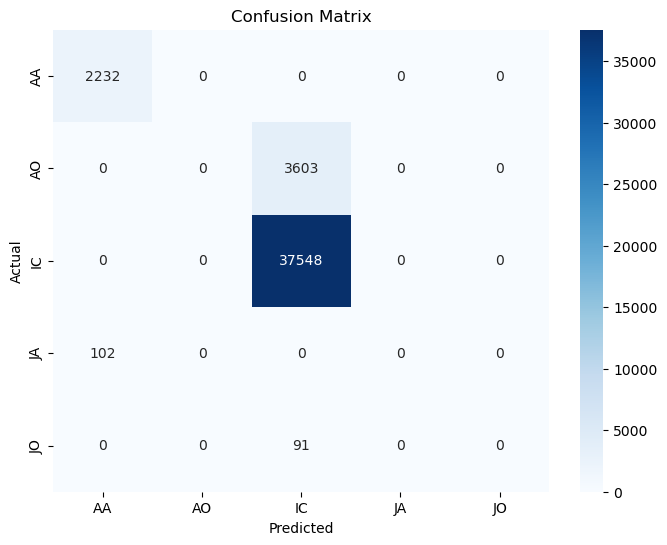

In [20]:
# Confusion Matrix
# Class labels
class_labels=['AA', 'AO', 'IC', 'JA', 'JO']

plot_prediction_vs_test_categorical(y_tested, y_predicted, class_labels)